# Notebook structure:
* Categories distribution
* CountVectorizer + LogReg + TfidfVectorizer training with unbalanced dataset
* Balancing dataset
* Training LogReg & GB with Tfidf & CountVectorizer on balanced dataset
* Feature importances + greater&smaller weights
* Trying word2vec + training models

**Dataset:** Top 100 films + low-rating films

**Dataset shape:** 60058∗2

Reviews: reviews without nltk.stopwords, without tags, with lemmatization

In [1]:
%cd ../..

from datasets.getters import  load_reviews_Review_Label_clean

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dill

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from sklearn.linear_model import LogisticRegression 
from nltk.tokenize import TreebankWordTokenizer, TweetTokenizer
import nltk
from sklearn.utils import resample
from sklearn.ensemble import GradientBoostingClassifier
import catboost as cb
from gensim.models import Word2Vec

from pprint import pprint

from pymystem3 import Mystem

np.set_printoptions(threshold=np.inf)

In [2]:
reviews = load_reviews_Review_Label_clean()
reviews

,review,label
0,«зелёный милю» смотреть раз : 10 год назад сей...,NEUTRAL
1,период конец девяностый годов-начало двухтысяч...,POSITIVE
2,"очень сложно писать рецензия фильм , это прост...",POSITIVE
3,любимый многий миллион ценитель киноискусство ...,POSITIVE
4,наш мир существовать разный фильмов. один цепл...,POSITIVE
...,...,...
60053,"исключение легендарный 'челюсть ' , качественн...",NEUTRAL
60054,действие фильм происходить космический корабле...,NEGATIVE
60055,"стоить поверить низкий оценка смотреть фильм ,...",NEGATIVE
60056,"повестись , каждый фильм жанр фантастика , кот...",NEGATIVE


In [3]:
reviews.label.value_counts()

POSITIVE    47847
NEUTRAL      6744
NEGATIVE     5467
Name: label, dtype: int64

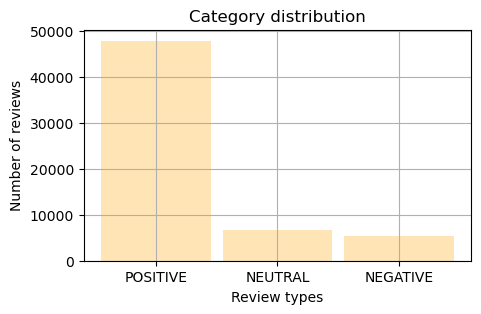

In [4]:
fig, ax = plt.subplots(figsize=(5, 3))

ax.bar(reviews.label.value_counts().index, 
       reviews.label.value_counts().values, 
       color = 'moccasin', width = 0.9)
plt.title("Category distribution")
plt.xlabel("Review types")
plt.ylabel("Number of reviews")
plt.grid(True)

In [5]:
label_encoding = {
    'POSITIVE': 2,
    'NEUTRAL': 1,
    'NEGATIVE': 0
}

In [6]:
reviews.label = reviews.label.apply(lambda label: label_encoding[label])
reviews

,review,label
0,«зелёный милю» смотреть раз : 10 год назад сей...,1
1,период конец девяностый годов-начало двухтысяч...,2
2,"очень сложно писать рецензия фильм , это прост...",2
3,любимый многий миллион ценитель киноискусство ...,2
4,наш мир существовать разный фильмов. один цепл...,2
...,...,...
60053,"исключение легендарный 'челюсть ' , качественн...",1
60054,действие фильм происходить космический корабле...,0
60055,"стоить поверить низкий оценка смотреть фильм ,...",0
60056,"повестись , каждый фильм жанр фантастика , кот...",0


In [7]:
reviews = reviews[reviews.label != 1].reset_index().drop(columns=['index'])
reviews

,review,label
0,период конец девяностый годов-начало двухтысяч...,2
1,"очень сложно писать рецензия фильм , это прост...",2
2,любимый многий миллион ценитель киноискусство ...,2
3,наш мир существовать разный фильмов. один цепл...,2
4,1999 год фильм увидел. показывать местный тв. ...,2
...,...,...
53309,"хотеть знать , 'осторожно ! ребёнок играть ' о...",0
53310,непотопляемый ( право славиться свой долгожите...,2
53311,действие фильм происходить космический корабле...,0
53312,"стоить поверить низкий оценка смотреть фильм ,...",0


In [8]:
train, test = train_test_split(reviews, test_size=0.3, random_state=42)
print(train.shape, test.shape)
train

(37319, 2) (15995, 2)


,review,label
43974,всё-таки продюсерский жадность - дело удивител...,2
20438,самый зрелищный фильм 2007 год — «пират карибс...,2
5134,второй фильм заметно первого. «два крепости» с...,2
6870,"микки маус научиться летать , обязательно спас...",2
33304,"парить воздух гора , птица удивительный расцве...",2
...,...,...
11284,... ввернуть идея подсознание человек сон ... ...,2
44732,"фильм потрясающий. мало , необычен. необычный ...",2
38158,кто-то заметить : человек жаждать сэкономить н...,2
860,"фильм , который неизменно занимать первый мест...",2


In [9]:
# cnt_vec_text = CountVectorizer()
# train_vectorized = cnt_vec_text.fit_transform(train.review)
# train_vectorized

In [10]:
# cnt_vec_text.vocabulary_

---

In [11]:
cnt_vec = CountVectorizer(tokenizer=TreebankWordTokenizer().tokenize)
X_train = cnt_vec.fit_transform(train.review)
X_test  = cnt_vec.transform(test.review)

print('CountVectorizing finished.')

clf = LogisticRegression(max_iter=200, n_jobs=-1)
clf.fit(X_train, train.label)
pred = clf.predict(X_test)

print(f1_score(test.label, pred, pos_label=2))
print(f1_score(test.label, pred, pos_label=0))
print(classification_report(test.label, pred))

CountVectorizing finished.
0.9714029459450135
0.7237587470843053
              precision    recall  f1-score   support

           0       0.78      0.68      0.72      1608
           2       0.96      0.98      0.97     14387

    accuracy                           0.95     15995
   macro avg       0.87      0.83      0.85     15995
weighted avg       0.95      0.95      0.95     15995



In [12]:
cnt_vec = TfidfVectorizer(tokenizer=TreebankWordTokenizer().tokenize)
X_train = cnt_vec.fit_transform(train.review)
X_test  = cnt_vec.transform(test.review)

print('TfidfVectorizing finished.')

clf = LogisticRegression(max_iter=200, n_jobs=-1)
clf.fit(X_train, train.label)
pred = clf.predict(X_test)

print(f1_score(test.label, pred, pos_label=2))
print(f1_score(test.label, pred, pos_label=0))
print(classification_report(test.label, pred))

TfidfVectorizing finished.
0.9648058252427185
0.5511607910576096
              precision    recall  f1-score   support

           0       0.89      0.40      0.55      1608
           2       0.94      0.99      0.96     14387

    accuracy                           0.93     15995
   macro avg       0.91      0.70      0.76     15995
weighted avg       0.93      0.93      0.92     15995



In [12]:
cnt_vec = TfidfVectorizer(tokenizer=TreebankWordTokenizer().tokenize)
X_train = cnt_vec.fit_transform(train.review)
X_test  = cnt_vec.transform(test.review)

print('TfidfVectorizing finished.')

clf = LogisticRegression(max_iter=200, n_jobs=-1, class_weight='balanced')
clf.fit(X_train, train.label)
pred = clf.predict(X_train)

print(f1_score(train.label, pred, pos_label=2))
print(f1_score(train.label, pred, pos_label=0))
print(classification_report(train.label, pred))

TfidfVectorizing finished.
0.9723006134969324
0.8086458995549904
              precision    recall  f1-score   support

           0       0.68      0.99      0.81      3859
           2       1.00      0.95      0.97     33460

    accuracy                           0.95     37319
   macro avg       0.84      0.97      0.89     37319
weighted avg       0.97      0.95      0.96     37319



In [14]:
cnt_vec = CountVectorizer(tokenizer=TreebankWordTokenizer().tokenize)
X_train = cnt_vec.fit_transform(train.review)
X_test  = cnt_vec.transform(test.review)

print('CountVectorizing finished.')

clf = LogisticRegression(max_iter=200, n_jobs=-1, class_weight='balanced')
clf.fit(X_train, train.label)
pred = clf.predict(X_test)

print(f1_score(test.label, pred, pos_label=2))
print(f1_score(test.label, pred, pos_label=0))
print(classification_report(test.label, pred))

CountVectorizing finished.
0.9697075208913649
0.7339449541284405
              precision    recall  f1-score   support

           0       0.72      0.75      0.73      1608
           2       0.97      0.97      0.97     14387

    accuracy                           0.95     15995
   macro avg       0.85      0.86      0.85     15995
weighted avg       0.95      0.95      0.95     15995



In [15]:
pred = clf.predict(X_test)

print(f1_score(test.label, pred, pos_label=2))
print(f1_score(test.label, pred, pos_label=0))
print(classification_report(test.label, pred))

0.9697075208913649
0.7339449541284405
              precision    recall  f1-score   support

           0       0.72      0.75      0.73      1608
           2       0.97      0.97      0.97     14387

    accuracy                           0.95     15995
   macro avg       0.85      0.86      0.85     15995
weighted avg       0.95      0.95      0.95     15995



**Почему такая разница в метриках между `CountVectorizer` и `TfidfVectorizer`?**

#### Balancing dataset

[SMOTE: метод увеличения числа примеров миноритарного класса](https://medium.com/nuances-of-programming/smote-%D0%BC%D0%B5%D1%82%D0%BE%D0%B4-%D1%83%D0%B2%D0%B5%D0%BB%D0%B8%D1%87%D0%B5%D0%BD%D0%B8%D1%8F-%D1%87%D0%B8%D1%81%D0%BB%D0%B0-%D0%BF%D1%80%D0%B8%D0%BC%D0%B5%D1%80%D0%BE%D0%B2-%D0%BC%D0%B8%D0%BD%D0%BE%D1%80%D0%B8%D1%82%D0%B0%D1%80%D0%BD%D0%BE%D0%B3%D0%BE-%D0%BA%D0%BB%D0%B0%D1%81%D1%81%D0%B0-da91a62f9914)
> Другим вариантом является увеличение примеров миноритарного класса. Иными словами, случайным образом дублируются образцы миноритарного класса. Проблема этого подхода заключается в том, что он приводит к чрезмерному обучению, поскольку модель обучается на одних и тех же примерах.

In [13]:
train.label.value_counts()

2    33460
0     3859
Name: label, dtype: int64

In [14]:
train

,review,label
43974,всё-таки продюсерский жадность - дело удивител...,2
20438,самый зрелищный фильм 2007 год — «пират карибс...,2
5134,второй фильм заметно первого. «два крепости» с...,2
6870,"микки маус научиться летать , обязательно спас...",2
33304,"парить воздух гора , птица удивительный расцве...",2
...,...,...
11284,... ввернуть идея подсознание человек сон ... ...,2
44732,"фильм потрясающий. мало , необычен. необычный ...",2
38158,кто-то заметить : человек жаждать сэкономить н...,2
860,"фильм , который неизменно занимать первый мест...",2


In [15]:
train[train.label == 0]

,review,label
3007,"выйти очередной фильм кристофер нолан , событи...",0
23467,"такой предположение , актёр играть ... вообще ...",0
42716,"пятнадцать год , первый прочтение книга кизя ,...",0
6700,наделать шум прошлый 2008 год очередной киноко...,0
51369,полнота картина хватать балалайка медведь улиц...,0
...,...,...
43021,"время просмотр фильм показаться сильный , отме...",0
43323,"фильм слышать друг , знакомый вообще мужиков. ...",0
189,слышать фильм заглянуть топ 250 кинопоиска. по...,0
25658,"наверно сказать я страшно непопулярный , всё-т...",0


In [16]:
train = pd.concat([train, resample(train[train.label == 0], n_samples=29500, random_state=42)])
train

,review,label
43974,всё-таки продюсерский жадность - дело удивител...,2
20438,самый зрелищный фильм 2007 год — «пират карибс...,2
5134,второй фильм заметно первого. «два крепости» с...,2
6870,"микки маус научиться летать , обязательно спас...",2
33304,"парить воздух гора , птица удивительный расцве...",2
...,...,...
25997,"представлять свой объективный мнение , ибо кни...",0
52959,"понимать , компьютер попасть фильм. серьезно. ...",0
24897,"дама господин , фильм настолько разочаровать ,...",0
27699,властелин кольцо безусловно хороший кинотрилог...,0


In [17]:
train.label.value_counts()

2    33460
0    33359
Name: label, dtype: int64

#### Training & Exploring `CountVectorizer`

In [11]:
%%time

cnt_vec = CountVectorizer(tokenizer=TreebankWordTokenizer().tokenize, max_df=0.6, max_features=1000)
X_train = cnt_vec.fit_transform(train.review)
print(f'{X_train.shape=}')
X_test  = cnt_vec.transform(test.review)

print('CountVectorizing finished.')

clf = LogisticRegression(max_iter=200, n_jobs=-1)
clf.fit(X_train, train.label)
pred = clf.predict(X_test)

print(f1_score(test.label, pred, pos_label=2))
print(f1_score(test.label, pred, pos_label=0))
print(classification_report(test.label, pred))

X_train.shape=(37319, 1000)
CountVectorizing finished.
0.9626786387470442
0.6125933831376735
              precision    recall  f1-score   support

           0       0.72      0.54      0.61      1608
           2       0.95      0.98      0.96     14387

    accuracy                           0.93     15995
   macro avg       0.83      0.76      0.79     15995
weighted avg       0.93      0.93      0.93     15995

Wall time: 50.7 s


In [19]:
print(len(cnt_vec.get_feature_names_out()))
cnt_vec.get_feature_names_out()[:30]

1000


array(['!', '%', "'", '(', ')', '-', '.', '...', '1', '2', '3', '3d', '4',
       '5', '8', '9', ':', ';', '?', '»', 'абсолютно', 'автор', 'актриса',
       'актёр', 'актёрский', 'алиса', 'америка', 'американец',
       'американский', 'армия'], dtype=object)

In [20]:
# Just watching...
clf.decision_function(X_train[:10])  # Confidence scores for each sample

array([ 2.98113515e+00,  3.78216115e+00, -3.18933806e-01, -3.30459246e+00,
       -1.18534020e-02, -3.86244787e+00,  2.06051868e+00,  1.45943519e-01,
        1.14235978e+00,  1.46798393e+01])

In [21]:
cnt_vec.get_feature_names_out()[np.argpartition(clf.coef_[0], -30)[-30:]]

array(['отдельный', 'замечательный', 'спасибо', 'продолжение', 'обладать',
       'шикарный', 'пересматривать', 'невозможно', 'советовать',
       'приятный', 'отличный', 'вера', 'подобрать', 'приятно', 'элемент',
       'триллер', 'порой', 'одновременно', 'роберт', 'отлично', 'рон',
       'потрясать', '9', 'идеальный', '8', 'идеально', 'суметь',
       'удивительный', 'впервые', 'звучать'], dtype=object)

In [22]:
cnt_vec.get_feature_names_out()[np.argpartition(clf.coef_[0], 30)[:30]]

array(['разочарование', 'пустой', 'откровенно', 'поведение', 'неужели',
       'бред', 'непонятно', 'вместо', 'попытка', 'потратить', 'похоже',
       'увы', '4', '5', 'джейн', 'скучный', 'бедный', 'неплохой',
       'логика', 'середина', 'оценка', 'слабый', 'сожаление', 'рейтинг',
       'голливуд', 'нести', 'видимо', 'банальный', 'глупый', 'надеяться'],
      dtype=object)

In [82]:
np.argpartition(np.abs(clf.coef_[0]), -10)[-10:]

array([519,  20, 583, 205,  35,  21, 408,  18,  17,  16], dtype=int64)

In [19]:
# _X_train = X_train.toarray()
# _X_train.shape

(18569, 1000)

In [37]:
s = np.array(np.sum(X_train, axis=0))[0]
s.shape

(1000,)

In [39]:
np.sort(s)[::-1][:5000]

array([138146, 130778, 116080, 112399, 104244,  98762,  92826,  84273,
        79316,  76593,  75977,  67780,  64852,  58501,  57771,  52409,
        49618,  49334,  48890,  48092,  47169,  46114,  46072,  43608,
        42029,  41457,  41266,  41240,  41100,  40195,  39197,  39095,
        38709,  38365,  37208,  36591,  36559,  36461,  34091,  33717,
        33623,  33306,  33047,  31084,  30643,  29678,  29449,  29198,
        28929,  28716,  28694,  27906,  27858,  27408,  27317,  26830,
        26814,  26491,  26127,  26011,  25932,  25866,  24829,  24784,
        24646,  24564,  24436,  23601,  23543,  23498,  22844,  22534,
        21875,  21371,  21278,  20294,  20284,  19992,  19941,  19896,
        19644,  19588,  19441,  19394,  19003,  18966,  18819,  18468,
        18307,  18271,  18260,  18127,  18081,  17721,  17446,  17218,
        17044,  17016,  16839,  16727,  16707,  16542,  16499,  16337,
        16105,  16023,  15907,  15514,  15436,  15430,  15278,  15265,
      

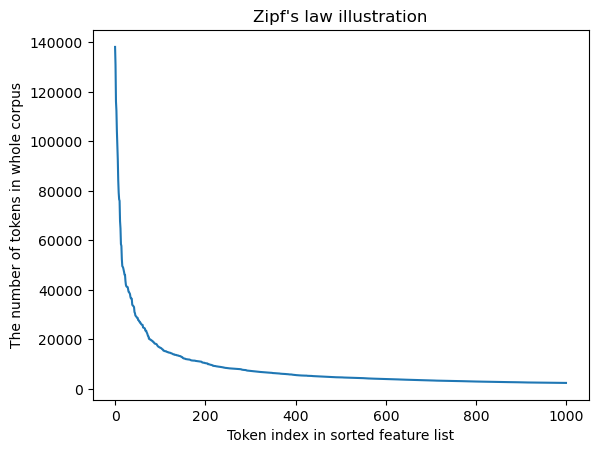

In [40]:
plt.plot(np.sort(s)[::-1])
plt.xlabel('Token index in sorted feature list')
plt.ylabel('The number of tokens in whole corpus')
plt.title("Zipf's law illustration")
plt.show()

#### What if binary coding chosen?

In [41]:
cnt_vec = CountVectorizer(tokenizer=TreebankWordTokenizer().tokenize, max_df=0.6, max_features=1000, binary=True)
X_train = cnt_vec.fit_transform(train.review)
print(f'{X_train.shape=}')
X_test  = cnt_vec.transform(test.review)

print('CountVectorizing finished.')

clf = LogisticRegression(max_iter=200, n_jobs=-1)
clf.fit(X_train, train.label)
pred = clf.predict(X_test)

print(f1_score(test.label, pred, pos_label=2))
print(f1_score(test.label, pred, pos_label=0))
print(classification_report(test.label, pred))

X_train.shape=(66819, 1000)
CountVectorizing finished.
0.9280538681109566
0.5784734133790738
              precision    recall  f1-score   support

           0       0.44      0.84      0.58      1608
           2       0.98      0.88      0.93     14387

    accuracy                           0.88     15995
   macro avg       0.71      0.86      0.75     15995
weighted avg       0.93      0.88      0.89     15995



*Nothing positive happened.*

#### GB Classifier testing

In [42]:
cnt_vec = CountVectorizer(tokenizer=TreebankWordTokenizer().tokenize, max_df=0.6, max_features=1000)
X_train = cnt_vec.fit_transform(train.review)
print(f'{X_train.shape=}')
X_test  = cnt_vec.transform(test.review)

print('CountVectorizing finished.')

clf = GradientBoostingClassifier()
clf.fit(X_train, train.label)
pred = clf.predict(X_test)

print(f1_score(test.label, pred, pos_label=2))
print(f1_score(test.label, pred, pos_label=0))
print(classification_report(test.label, pred))

X_train.shape=(66819, 1000)
CountVectorizing finished.
0.901611218857228
0.4905368868288914
              precision    recall  f1-score   support

           0       0.36      0.79      0.49      1608
           2       0.97      0.84      0.90     14387

    accuracy                           0.84     15995
   macro avg       0.66      0.81      0.70     15995
weighted avg       0.91      0.84      0.86     15995



In [43]:
len(clf.feature_importances_)

1000

In [44]:
cnt_vec.get_feature_names_out()[np.argpartition(clf.feature_importances_, -30)[-30:]]

array(['.', 'увы', 'пустой', 'отлично', 'откровенно', 'непонятно',
       'замечательный', 'скучный', 'великолепный', 'слишком', '?',
       'вообще', 'роль', '9', 'очень', '5', '4', 'настоящий', '3',
       'вместо', 'прекрасный', 'видимо', 'заставлять', 'какой-то',
       'жизнь', 'потрясать', 'никакой', 'каждый', 'разочарование',
       'плохой'], dtype=object)

In [45]:
# Все фичи на букву П!!!

cnt_vec.get_feature_names_out()[np.argpartition(clf.feature_importances_, 30)[:30]]

array(['потерять', 'постоянно', 'природа', 'принять', 'принцип', 'пример',
       'прийтись', 'прийти', 'признаться', 'придумать', 'прежде',
       'предыдущий', 'представлять', 'представить', 'превратиться',
       'практически', 'право', 'правильный', 'правило', 'правда',
       'появляться', 'появление', 'появиться', 'поэтому', 'почему-то',
       'похожий', 'приходить', 'поступок', 'помочь', 'помощь'],
      dtype=object)